# Benchmark `oxidized_thainlp.segment`

Benchmarks Rust `oxidized_thainlp.segment` (unsafe) against Python `newmm.segment` (unsafe) using the same dictionary.

https://github.com/PyThaiNLP/oxidized-thainlp/

In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm


def time_func(func, arg):
    start_time = time.time()
    func(arg)
    return time.time() - start_time

## Load Custom Dictionary to the Tokenizers

Both `oxidized_newmm()` and `py_newmm()` will use the same word list (`words_th.txt`)

In [2]:
DICT_FILE = "../words_th.txt"

In [3]:
from pythainlp.tokenize.newmm import segment as py_segment
from pythainlp.util import dict_trie

trie = dict_trie(dict_source=DICT_FILE)

def py_newmm(txt, safe_mode=False):
    return py_segment(txt, safe_mode=safe_mode, custom_dict=trie)

In [4]:
from oxidized_thainlp import load_dict
from oxidized_thainlp import segment as oxidized_segment

load_dict(DICT_FILE, "test_dict")  # create "test_dict" dictionary

def oxidized_newmm(txt, safe=False, parallel=False):
    return oxidized_segment(txt, dict_name="test_dict", safe=safe, parallel=parallel)

Successful: dictionary name test_dict from file ../words_th.txt has been successfully loaded


## Load Test data

In [5]:
from datasets import load_dataset

datasets = load_dataset('wisesight_sentiment')
datasets

Reusing dataset wisesight_sentiment (/Users/test/.cache/huggingface/datasets/wisesight_sentiment/wisesight_sentiment/1.0.0/fc2b1bdfe79571b2e281e4afdb5aac069cf9270bf0f85694239be672a4191969)


DatasetDict({
    train: Dataset({
        features: ['category', 'texts'],
        num_rows: 21628
    })
    validation: Dataset({
        features: ['category', 'texts'],
        num_rows: 2404
    })
    test: Dataset({
        features: ['category', 'texts'],
        num_rows: 2671
    })
})

In [6]:
txt = datasets['train']['texts'][0]
txt

'ไปจองมาแล้วนาจา Mitsubishi Attrage ได้หลังสงกรานต์เลย รอขับอยู่นาจา กระทัดรัด เหมาะกับสาวๆขับรถคนเดียวแบบเรา ราคาสบายกระเป๋า ประหยัดน้ำมัน วิ่งไกลแค่ไหนหายห่วงค่ะ'

In [7]:
py_newmm(txt)[:10]

['ไป', 'จอง', 'มา', 'แล้', 'วนา', 'จา', ' ', 'Mitsubishi', ' ', 'Attrage']

In [8]:
oxidized_newmm(txt)[:10]

['ไป', 'จอง', 'มา', 'แล้', 'วนา', 'จา', ' ', 'Mitsubishi', ' ', 'Attrage']

## One Example

### Average Run Time for One Example

In [9]:
%timeit py_newmm(txt)

306 µs ± 7.78 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [10]:
%timeit oxidized_newmm(txt)

172 µs ± 2.58 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [11]:
%timeit oxidized_newmm(txt, parallel=True)

246 µs ± 4.55 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [12]:
%timeit py_newmm(txt, safe_mode=True)

306 µs ± 3.41 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [13]:
%timeit oxidized_newmm(txt, safe=True)

178 µs ± 3.65 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## All Examples

### Check If Results Match for All Examples

In [14]:
corrects = [oxidized_newmm(txt) == py_newmm(txt) for txt in datasets['train']['texts']]
np.mean(corrects), len(corrects)

(0.9999075272794525, 21628)

### Average Run Time Across All Examples

In [15]:
py_newmms = [time_func(py_newmm, txt) for txt in datasets['train']['texts']]
oxidized_newmms = [time_func(oxidized_newmm, txt) for txt in datasets['train']['texts']]

# oxidized newmm is nearly 2 times faster than python newmm, on average
np.mean(py_newmms), np.mean(oxidized_newmms), np.mean(py_newmms) / np.mean(oxidized_newmms)

(0.00019629587632396733, 0.00010808309654177988, 1.8161570366193989)

(array([1.5343e+04, 3.2270e+03, 1.2610e+03, 7.7200e+02, 3.3000e+02,
        2.2600e+02, 1.1900e+02, 7.8000e+01, 6.1000e+01, 5.3000e+01,
        3.4000e+01, 2.8000e+01, 1.2000e+01, 1.0000e+01, 1.1000e+01,
        9.0000e+00, 1.0000e+01, 1.2000e+01, 9.0000e+00, 4.0000e+00,
        5.0000e+00, 4.0000e+00, 5.0000e+00, 1.0000e+00, 0.0000e+00,
        3.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([4.76837158e-06, 1.00572904e-04, 1.96377436e-04, 2.92181969e-04,
        3.87986501e-04, 4.83791033e-04, 5.79595566e-04, 6.75400098e-04,
        7.71204631e-04, 8.67009163e-04, 9.62813695e-04, 1.05861823e-03,
        1.15442276e-03, 1.25022729e-03, 1.34603182e-03, 1.44183636e-03,
        1.53764089e-03, 1.63344542e-03, 1.72924995e-03, 1.82505449e-03,
        1.92085902e-03, 2.01666355e-03, 2.11246808e-03, 2.20827262e-03,
        2.30407715e-03, 2.39988168e-03, 2.49568621e-03, 2.59149075e-03,
        2.68729528e-03, 2.78309981e-03, 2.87890434e-03]),
 <BarContainer object of 30 

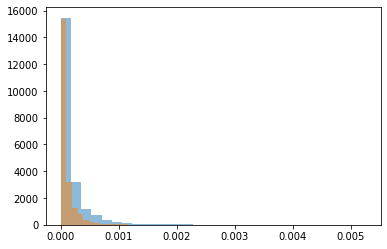

In [16]:
# look at distribution; oxidized newmm also consistently performs better
plt.hist(py_newmms, bins=30, alpha=0.5)
plt.hist(oxidized_newmms, bins=30, alpha=0.5)

## Run Time as Sequence Length Grows

In [17]:
txt = datasets['train']['texts'][1]
txt2 = ''.join(oxidized_newmm(txt)[:10])
txt2, len(oxidized_newmm(txt2))

('เปิดศักราชใหม่! นายกฯ แถลงข่าวก่อนการแข่งขัน', 10)

In [18]:
py_newmms = [time_func(py_newmm, txt2*i) for i in tqdm([10**j for j in range(5)])]
oxidized_newmms = [time_func(oxidized_newmm, txt2*i) for i in tqdm([10**j for j in range(5)])]

Performance starts really deviate when sequence length > 10^3 tokens and above.

python newmm is dashed line.

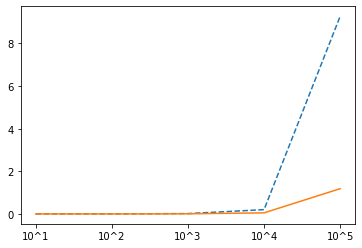

In [19]:
positions = [i for i in range(5)]
labels = [f'10^{i+1}' for i in range(5)]
plt.xticks(positions, labels)
plt.plot(py_newmms, linestyle='dashed')
plt.plot(oxidized_newmms)

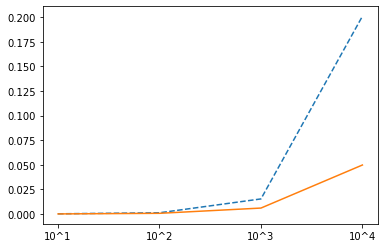

In [20]:
# zooming in on inflexion point
positions = [i for i in range(4)]
labels = [f'10^{i+1}' for i in range(4)]
plt.xticks(positions, labels)
plt.plot(py_newmms[:-1], linestyle='dashed')
plt.plot(oxidized_newmms[:-1])